In [1]:
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn import svm
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils import class_weight, resample
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report

In [2]:
df_treino = pd.read_csv("desafio_manutencao_preditiva_treino.csv")
df_teste = pd.read_csv("desafio_manutencao_preditiva_teste.csv")

# Definição dos tipos de variáveis

In [3]:
target = 'failure_type'
features = df_treino.columns.drop([target, 'udi', 'product_id'])
features

Index(['type', 'air_temperature_k', 'process_temperature_k',
       'rotational_speed_rpm', 'torque_nm', 'tool_wear_min'],
      dtype='object')

In [4]:
numerical = df_treino[features].select_dtypes('number').columns
numerical

Index(['air_temperature_k', 'process_temperature_k', 'rotational_speed_rpm',
       'torque_nm', 'tool_wear_min'],
      dtype='object')

In [5]:
categorical = 'type'

# Separação do dataset em entrada e saída (X e y)

In [6]:
X = df_treino[features]
y = df_treino[target] 

# Divisão do dataset em treino e validação

Como os dados de teste não possuem a variável target, é importante que separemos uma parte do dataset de treino para validar o modelo e garantir que não haja overfitting. Dividiremos então o dataset em treino e validação. Usaremos 25% dos dados para validação.

Além disso, é importante dividir os dados antes do pré-processamento para evitar uma falha chamada _data leakage_, que é o compartilhamento de informações entre o conjunto de dados usado no treinamento do modelo e o dataset usado para avaliação do modelo.

In [7]:
# Divisão em Dados de Treino e Validação.
X_treino, X_val, y_treino, y_val = train_test_split(X, y, test_size = 0.25, random_state = 101, stratify=y)

# Pré-Processamento dos Dados

Muitos algoritmos preditivos esperam receber os dados padronizados e codificados. Portanto, é necessário transformar os dados para adequá-los aos modelos.

In [8]:
# Cópia dos dados = boa prática
X_treino_copy = X_treino.copy()
y_treino_copy = y_treino.copy()
X_val_copy = X_val.copy()
y_val_copy = y_val.copy()

## Encoding da variável categórica

In [9]:
# Número de classes da variável categórica
X_treino[categorical].nunique()

3

A variável type possui apenas 3 classes, vamos aplicar a técnica de OneHotEncoding para sua codificação;

In [10]:
# OneHotEncoding
onehot = OneHotEncoder()
cat_encoded = onehot.fit_transform(X_treino[[categorical]])
X_treino[onehot.categories_[0]] = cat_encoded.toarray()
X_treino.drop(columns='type', inplace = True)
X_treino

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,H,L,M
2685,302.1,311.2,1598,37.9,148,1.0,0.0,0.0
2281,301.4,310.6,1630,30.3,2,0.0,0.0,1.0
202,298.0,308.3,1473,42.6,107,0.0,1.0,0.0
6057,297.3,308.1,1709,30.6,196,0.0,0.0,1.0
998,298.0,308.7,1436,48.2,201,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
5535,298.8,310.0,1295,52.7,74,0.0,0.0,1.0
1450,299.5,309.1,1420,49.5,5,0.0,0.0,1.0
769,297.1,308.0,1348,58.0,162,0.0,1.0,0.0
6508,298.7,309.6,1424,50.4,32,0.0,0.0,1.0


## Padronização e normalização das variáveis numéricas

Os dados podem ser padronizados ou normalizados. A padronização consiste em deixá-los numa distribuição normal com média 0 e desvio padrão 1. Já a normalização trata de deixar os dados numa escala única, geralmente de 0 a 1 ou de -1 a 1. 

Para os dados cuja distribuição não é gaussiana (ou normal), a normalização geralmente é uma melhor opção.

Para os dados nesse problema, será aplicada a padronização para as variáveis numéricas cuja distribuição é normal e a normalização para a variável tool_wear_min que tem uma distribuição uniforme.

In [11]:
scale = [col for col in numerical if col != 'tool_wear_min']
scaler = StandardScaler()
X_treino[scale] = scaler.fit_transform(X_treino[scale])

In [12]:
X_treino

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,H,L,M
2685,1.060613,0.813864,0.338430,-0.217692,148,1.0,0.0,0.0
2281,0.709081,0.410828,0.518479,-0.978057,2,0.0,0.0,1.0
202,-0.998362,-1.134143,-0.364888,0.252533,107,0.0,1.0,0.0
6057,-1.349894,-1.268489,0.962976,-0.948043,196,0.0,0.0,1.0
998,-0.998362,-0.865453,-0.573070,0.812802,201,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
5535,-0.596610,0.007792,-1.366413,1.263018,74,0.0,0.0,1.0
1450,-0.245078,-0.596762,-0.663095,0.942865,5,0.0,0.0,1.0
769,-1.450332,-1.335661,-1.068206,1.793273,162,0.0,1.0,0.0
6508,-0.646829,-0.260899,-0.640589,1.032908,32,0.0,0.0,1.0


In [13]:
normalize = ['tool_wear_min']
normalizer = MinMaxScaler()
X_treino[normalize] = normalizer.fit_transform(X_treino[normalize])
X_treino

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,H,L,M
2685,1.060613,0.813864,0.338430,-0.217692,0.601626,1.0,0.0,0.0
2281,0.709081,0.410828,0.518479,-0.978057,0.008130,0.0,0.0,1.0
202,-0.998362,-1.134143,-0.364888,0.252533,0.434959,0.0,1.0,0.0
6057,-1.349894,-1.268489,0.962976,-0.948043,0.796748,0.0,0.0,1.0
998,-0.998362,-0.865453,-0.573070,0.812802,0.817073,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
5535,-0.596610,0.007792,-1.366413,1.263018,0.300813,0.0,0.0,1.0
1450,-0.245078,-0.596762,-0.663095,0.942865,0.020325,0.0,0.0,1.0
769,-1.450332,-1.335661,-1.068206,1.793273,0.658537,0.0,1.0,0.0
6508,-0.646829,-0.260899,-0.640589,1.032908,0.130081,0.0,0.0,1.0


Na análise exploratória, vimos que as variáveis rotational_speed_rpm e torque_nm possuíam valores _outliers_, vamos verificar agora quantos valores desse existem no dataset de treino.

In [14]:
# União de todas as linhas onde uma das duas variáveis possui um outlier
outliers = pd.merge(X_treino.loc[abs(X_treino['rotational_speed_rpm']) > 3],
                    X_treino.loc[abs(X_treino['torque_nm']) > 3],
                    how='outer')
outliers

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,H,L,M
0,0.457986,0.007792,5.948093,-2.638855,0.841463,0.0,1.0,0.0
1,0.206892,0.343655,4.985954,-2.558816,0.048780,0.0,1.0,0.0
2,-0.998362,-1.201316,3.106689,-2.108600,0.581301,0.0,0.0,1.0
3,0.558424,0.746691,3.101062,-2.028562,0.658537,0.0,0.0,1.0
4,-1.349894,-1.134143,3.658090,-2.308696,0.130081,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
86,-1.400113,-1.402834,-1.191990,3.534108,0.699187,0.0,1.0,0.0
87,0.106454,0.679519,-1.591474,3.173936,0.605691,0.0,1.0,0.0
88,0.558424,0.276483,-1.270762,3.354022,0.199187,0.0,1.0,0.0
89,0.257111,-0.126553,-1.203243,3.273984,0.646341,1.0,0.0,0.0


In [15]:
# Proporção de outliers
len(outliers)/len(X_treino)

0.0182

Como a proporção de outliers é de menos de 2%, não há grande prejuízo em apenas remover essas linhas para que elas não comprometam o treinamento do modelo. 

In [16]:
X_treino = X_treino.loc[abs(X_treino['rotational_speed_rpm']) < 3]
X_treino = X_treino.loc[abs(X_treino['torque_nm']) < 3]
X_treino

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,H,L,M
2685,1.060613,0.813864,0.338430,-0.217692,0.601626,1.0,0.0,0.0
2281,0.709081,0.410828,0.518479,-0.978057,0.008130,0.0,0.0,1.0
202,-0.998362,-1.134143,-0.364888,0.252533,0.434959,0.0,1.0,0.0
6057,-1.349894,-1.268489,0.962976,-0.948043,0.796748,0.0,0.0,1.0
998,-0.998362,-0.865453,-0.573070,0.812802,0.817073,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
5535,-0.596610,0.007792,-1.366413,1.263018,0.300813,0.0,0.0,1.0
1450,-0.245078,-0.596762,-0.663095,0.942865,0.020325,0.0,0.0,1.0
769,-1.450332,-1.335661,-1.068206,1.793273,0.658537,0.0,1.0,0.0
6508,-0.646829,-0.260899,-0.640589,1.032908,0.130081,0.0,0.0,1.0


Se removemos essas linhas do dataset de entrada X, também as removeremos da saída y.

In [17]:
# Removendo as mesmas linhas do dataset y
y_treino = y_treino.loc[y_treino_copy.index.isin(X_treino.index)]
y_treino

2685    No Failure
2281    No Failure
202     No Failure
6057    No Failure
998     No Failure
           ...    
5535    No Failure
1450    No Failure
769     No Failure
6508    No Failure
830     No Failure
Name: failure_type, Length: 4909, dtype: object

## Encoding da variável target

In [18]:
# Número de classes da variável target
y_treino.nunique()

6

A variável target failure_type possui 6 classes distintas. Vamos aplicar a técnica de label encoding para sua codificação, a fim de que haja apenas uma coluna para a variável a ser prevista.

In [19]:
le = LabelEncoder()
y_treino = pd.Series(le.fit_transform(y_treino), index = y_treino.index)
y_treino

2685    1
2281    1
202     1
6057    1
998     1
       ..
5535    1
1450    1
769     1
6508    1
830     1
Length: 4909, dtype: int32

## Pré-processamento do dataset de validação

Agora, com as transformações treinadas, é preciso transformar todos os dados de validação da mesma forma que os dados de treinamento.

In [20]:
# Variável target
y_val = pd.Series(le.transform(y_val), index = y_val.index)

# One Hot Encoding
cat_encoded_val = onehot.transform(X_val[[categorical]])
X_val[onehot.categories_[0]] = cat_encoded_val.toarray()
X_val.drop(columns='type', inplace = True)

# Scaling
X_val[scale] = scaler.transform(X_val[scale])

# Normalizing
X_val[normalize] = normalizer.transform(X_val[normalize])

In [21]:
y_val

5089    1
2028    1
2438    1
4076    1
2330    4
       ..
6252    1
6532    1
6002    1
664     1
454     1
Length: 1667, dtype: int32

In [22]:
X_val

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,H,L,M
5089,0.206892,0.948209,0.698529,-1.078106,0.524390,0.0,1.0,0.0
2028,0.307330,-0.059381,-0.499925,0.232524,0.686992,0.0,0.0,1.0
2438,1.060613,0.881037,-0.691228,0.402605,0.174797,0.0,1.0,0.0
4076,0.457986,0.612346,-0.342382,0.142480,0.406504,0.0,1.0,0.0
2330,0.809518,0.343655,0.360936,-0.777961,0.008130,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
6252,-1.249456,-1.335661,2.785976,-2.338711,0.520325,0.0,0.0,1.0
6532,-0.747267,-0.529589,1.030495,-1.068101,0.691057,0.0,0.0,1.0
6002,-1.400113,-1.335661,0.940470,-1.408264,0.813008,0.0,1.0,0.0
664,-1.902302,-2.141734,0.659143,-0.898019,0.552846,0.0,1.0,0.0


## Balanceamento das classes da variável target

A última etapa do pré-processamento é balancear as instâncias da variável target. Como visto na Análise Exploratória, há muito mais máquinas sem falhas do que com os 5 tipos de falhas apresentados. Se o modelo preditivo for alimentado dessa forma, ele aprenderá muito melhor sobre máquinas sem falhas do que sobre máquinas com falhas, portanto, é preciso aplicar alguma técnica de balanceamento de classes.

Pode-se aplicar o _oversampling_, que cria mais registros das classes que minoritárias ou o _undersampling_, que remove registros das classes majoritárias. 

O dataset possui poucos registros - apenas cerca de 6,5 mil - portanto, se aplicado o _undersampling_, teremos ainda menos dados para o treinamento e perderemos características demais sobre os dados.

O _oversampling_ também não funcionaria muito bem para esse modelo, visto que a diferença entre as classes é muito grande e são muitas classes, o que faria com que fossem seriam criados registros artificias demais para resolver a diferença.

A abordagem que faremos será a de converter o problema de classificação multiclasse em um problema de classificação binário, respondendo a pergunta: "Há ou não falha nas máquinas?". Com essa mudança na pergunta-chave do problema, haverão apenas duas classes a serem balanceadas, e poderemos então aplicar uma técnica de _oversampling_, nesse caso o SMOTE. Após respondido esse primeiro questionamento, abordaremos então, para as máquinas em que o modelo previu falha, qual o tipo de falha presente, se houver.

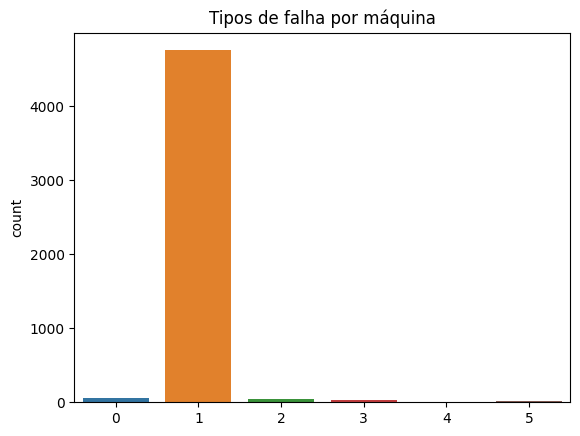

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x=y_treino)
plt.title('Tipos de falha por máquina');

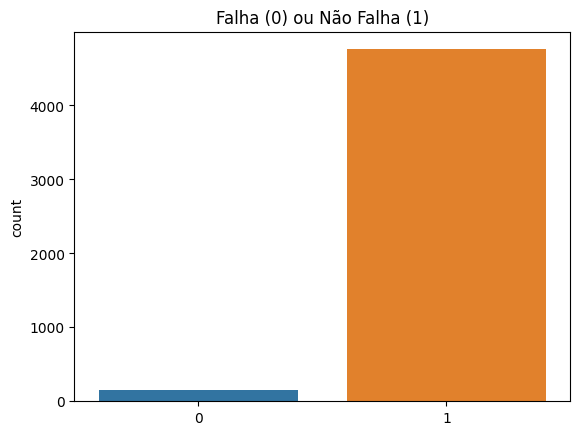

In [24]:
# Definindo o y_treino binário - falha ou não falha
y_treino_bin, y_val_bin = y_treino.where(y_treino == 1, 0), y_val.where(y_val == 1, 0)

# Plot
sns.countplot(x=y_treino_bin)
plt.title('Falha (0) ou Não Falha (1)');

In [25]:
# Cria o objeto balanceador
smote = SMOTE(random_state = 1337)

# Aplica o balanceador
X_res, y_res = smote.fit_resample(X_treino, y_treino_bin)

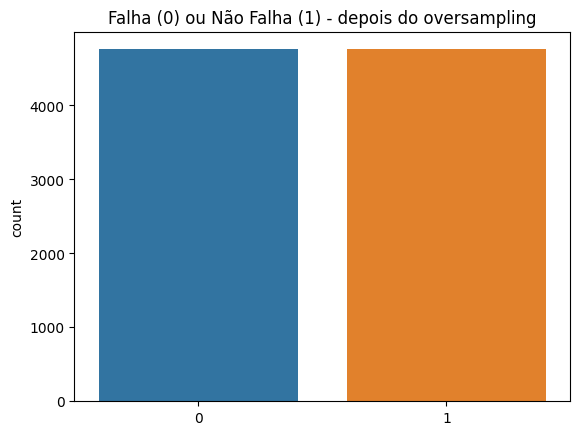

In [26]:
sns.countplot(x=y_res)
plt.title('Falha (0) ou Não Falha (1) - depois do oversampling');

# Criação do Modelo Preditivo - Classificação Binária

Após toda a etapa de Análise Exploratória e Pré-Processamento de Dados, podemos finalmente começar a criar e avaliar os modelos preditivos para esse problema. Como o problema é para prever uma classe, um tipo de falha, então é um problema de classificação. Mais especificamente, classificação multiclasse, visto que a variável target possui mais de 2 classes possíveis. No entanto, como mencionado anteriormente, primeiro transformaremos essa classificação multiclasse em classificação binária, e depois faremos a mudança para classificação multiclasse apenas daquelas máquinas em que uma falha for prevista.

Entre os algoritmos mais comuns para esse tipo de problema estão:
Regressão Logística, KNN, Naive Bayes, Decision Tree, SVM (Support Vector Machines) e Redes Neurais.

Criaremos alguns modelos e utilizaremos algumas métricas de avaliação.

In [27]:
# Criando a função que treina e avalia o modelo
def train_and_score_model(algoritmo, X_treino, y_treino, X_teste, y_teste, nome = None, version = '1'):
    # Cria o modelo
    modelo = algoritmo
    
    # Treinamento
    start = time.time()
    modelo.fit(X_treino, y_treino)
    end = time.time()
    print('Tempo de Treinamento do Modelo:', end - start)
    
    # Fazendo as previsões para o dataset de teste
    previsoes = modelo.predict(X_teste)
    
    # Avaliação do modelo
    # Matriz de confusão
    print('\nMatriz de confusão\n', confusion_matrix(y_teste, previsoes))
    
    # Dicionário de métricas e metadados
    dict_model =   {'Modelo': nome,
                    'Versão': version,
                    'Precision':precision_score(y_teste, previsoes),
                    'Recall':recall_score(y_teste, previsoes),
                    'F1 Score':f1_score(y_teste, previsoes),
                    'Acurácia':accuracy_score(y_teste, previsoes)}
        
    return modelo, dict_model, previsoes

In [28]:
# Modelo 1 - KNN
modelo1, dict1, previsoes1 = train_and_score_model(KNeighborsClassifier(), X_treino, y_treino_bin, X_val, y_val_bin, nome = 'KNN', 
                              version = 'Binary Classification 1')
dict1

Tempo de Treinamento do Modelo: 0.011992692947387695

Matriz de confusão
 [[   6   52]
 [   6 1603]]


{'Modelo': 'KNN',
 'Versão': 'Binary Classification 1',
 'Precision': 0.9685800604229607,
 'Recall': 0.9962709757613425,
 'F1 Score': 0.9822303921568628,
 'Acurácia': 0.9652069586082783}

In [29]:
# Modelo 2 - Naive Bayes
modelo2, dict2, previsoes2 = train_and_score_model(GaussianNB(), X_treino, y_treino_bin, X_val, y_val_bin, nome = 'Naive Bayes', 
                              version = 'Binary Classification 1')
dict2

Tempo de Treinamento do Modelo: 0.0030279159545898438

Matriz de confusão
 [[  19   39]
 [  14 1595]]


{'Modelo': 'Naive Bayes',
 'Versão': 'Binary Classification 1',
 'Precision': 0.9761321909424725,
 'Recall': 0.9912989434431324,
 'F1 Score': 0.9836571076164047,
 'Acurácia': 0.9682063587282543}

In [30]:
# Modelo 3 - Decision Tree Classifier
modelo3, dict3, previsoes3 = train_and_score_model(DecisionTreeClassifier(), X_treino, y_treino_bin, X_val, y_val_bin, nome = 'Decision Tree Classifier', 
                              version = 'Binary Classification 1')
dict3

Tempo de Treinamento do Modelo: 0.013998985290527344

Matriz de confusão
 [[  30   28]
 [  11 1598]]


{'Modelo': 'Decision Tree Classifier',
 'Versão': 'Binary Classification 1',
 'Precision': 0.982779827798278,
 'Recall': 0.9931634555624611,
 'F1 Score': 0.9879443585780525,
 'Acurácia': 0.9766046790641871}

In [31]:
# Modelo 4 - Decision Tree Classifier
modelo4, dict4, previsoes4 = train_and_score_model(RandomForestClassifier(), X_treino, y_treino_bin, X_val, y_val_bin, nome = 'Random Forest Classifier', 
                              version = 'Binary Classification 1')
dict4

Tempo de Treinamento do Modelo: 0.4569895267486572

Matriz de confusão
 [[  25   33]
 [   1 1608]]


{'Modelo': 'Random Forest Classifier',
 'Versão': 'Binary Classification 1',
 'Precision': 0.979890310786106,
 'Recall': 0.9993784959602238,
 'F1 Score': 0.9895384615384615,
 'Acurácia': 0.9796040791841631}

In [32]:
# Modelo 5 - SVM Classifier
modelo5, dict5, previsoes5 = train_and_score_model(svm.SVC(), X_treino, y_treino_bin, X_val, y_val_bin, nome = 'SVM Classifier', 
                                      version = 'Binary Classification 1')
dict5

Tempo de Treinamento do Modelo: 0.09900069236755371

Matriz de confusão
 [[   1   57]
 [   0 1609]]


{'Modelo': 'SVM Classifier',
 'Versão': 'Binary Classification 1',
 'Precision': 0.9657863145258103,
 'Recall': 1.0,
 'F1 Score': 0.9825954198473282,
 'Acurácia': 0.9658068386322736}

In [33]:
# Modelo 6 - XGBoost Classifier
modelo6, dict6, previsoes = train_and_score_model(svm.SVC(), X_treino, y_treino_bin, X_val, y_val_bin, nome = 'XGBoost Classifier', 
                              version = 'Binary Classification 1')
dict6

Tempo de Treinamento do Modelo: 0.09499192237854004

Matriz de confusão
 [[   1   57]
 [   0 1609]]


{'Modelo': 'XGBoost Classifier',
 'Versão': 'Binary Classification 1',
 'Precision': 0.9657863145258103,
 'Recall': 1.0,
 'F1 Score': 0.9825954198473282,
 'Acurácia': 0.9658068386322736}

In [34]:
# Concatena todos os dicionários em um dataframe do Pandas
resumo_bin1 = pd.DataFrame({'dict1':pd.Series(dict1),
                           'dict2':pd.Series(dict2),
                           'dict3':pd.Series(dict3),
                           'dict4':pd.Series(dict4),
                           'dict5':pd.Series(dict5),
                           'dict6':pd.Series(dict6)})

resumo_bin1

,dict1,dict2,dict3,dict4,dict5,dict6
Modelo,KNN,Naive Bayes,Decision Tree Classifier,Random Forest Classifier,SVM Classifier,XGBoost Classifier
Versão,Binary Classification 1,Binary Classification 1,Binary Classification 1,Binary Classification 1,Binary Classification 1,Binary Classification 1
Precision,0.96858,0.976132,0.98278,0.97989,0.965786,0.965786
Recall,0.996271,0.991299,0.993163,0.999378,1.0,1.0
F1 Score,0.98223,0.983657,0.987944,0.989538,0.982595,0.982595
Acurácia,0.965207,0.968206,0.976605,0.979604,0.965807,0.965807


## Repetindo os modelos com o balanceamento de classes (SMOTE)

In [35]:
# Modelo 1 - KNN - com SMOTE
modelo1, dict1, previsoes1 = train_and_score_model(KNeighborsClassifier(), X_res, y_res, X_val, y_val_bin, nome = 'KNN', 
                                          version = 'Binary Classification 2')
dict1

Tempo de Treinamento do Modelo: 0.021992921829223633

Matriz de confusão
 [[  36   22]
 [ 107 1502]]


{'Modelo': 'KNN',
 'Versão': 'Binary Classification 2',
 'Precision': 0.9855643044619422,
 'Recall': 0.9334990677439403,
 'F1 Score': 0.9588254069581871,
 'Acurácia': 0.9226154769046191}

In [36]:
# Modelo 2 - Naive Bayes - com SMOTE
modelo2, dict2, previsoes2 = train_and_score_model(GaussianNB(), X_res, y_res, X_val, y_val_bin, nome = 'Naive Bayes', 
                                          version = 'Binary Classification 2')
dict2

Tempo de Treinamento do Modelo: 0.003997802734375

Matriz de confusão
 [[  40   18]
 [ 481 1128]]


{'Modelo': 'Naive Bayes',
 'Versão': 'Binary Classification 2',
 'Precision': 0.9842931937172775,
 'Recall': 0.7010565568676196,
 'F1 Score': 0.8188747731397459,
 'Acurácia': 0.7006598680263947}

In [37]:
# Modelo 3 - Decision Tree - com SMOTE
modelo3, dict3, previsoes3 = train_and_score_model(DecisionTreeClassifier(), X_res, y_res, X_val, y_val_bin, nome = 'Decision Tree Classifier', 
                                          version = 'Binary Classification 2')
dict3

Tempo de Treinamento do Modelo: 0.03700137138366699

Matriz de confusão
 [[  38   20]
 [  52 1557]]


{'Modelo': 'Decision Tree Classifier',
 'Versão': 'Binary Classification 2',
 'Precision': 0.9873176918199112,
 'Recall': 0.9676817899316346,
 'F1 Score': 0.9774011299435029,
 'Acurácia': 0.9568086382723455}

In [38]:
# Modelo 4 - Random Forest - com SMOTE
modelo4, dict4, previsoes4 = train_and_score_model(RandomForestClassifier(), X_res, y_res, X_val, y_val_bin, nome = 'Random Forest Classifier', 
                                          version = 'Binary Classification 2')
dict4

Tempo de Treinamento do Modelo: 1.2219958305358887

Matriz de confusão
 [[  36   22]
 [  39 1570]]


{'Modelo': 'Random Forest Classifier',
 'Versão': 'Binary Classification 2',
 'Precision': 0.9861809045226131,
 'Recall': 0.9757613424487259,
 'F1 Score': 0.9809434551702594,
 'Acurácia': 0.9634073185362927}

In [39]:
# Modelo 5 - SVM Classifier - com SMOTE
modelo5, dict5, previsoes5 = train_and_score_model(RandomForestClassifier(), X_res, y_res, X_val, y_val_bin, nome = 'SVM Classifier', 
                                          version = 'Binary Classification 2')
dict5

Tempo de Treinamento do Modelo: 1.2119927406311035

Matriz de confusão
 [[  37   21]
 [  42 1567]]


{'Modelo': 'SVM Classifier',
 'Versão': 'Binary Classification 2',
 'Precision': 0.9867758186397985,
 'Recall': 0.9738968303293971,
 'F1 Score': 0.980294025649046,
 'Acurácia': 0.9622075584883023}

In [40]:
# Modelo 6 - XGBoost Classifier - com SMOTE
modelo6, dict6, previsoes6 = train_and_score_model(XGBClassifier(), X_res, y_res, X_val, y_val_bin, nome = 'XGBoost Classifier', 
                                          version = 'Binary Classification 2')
dict6

Tempo de Treinamento do Modelo: 0.3489987850189209

Matriz de confusão
 [[  36   22]
 [  30 1579]]


{'Modelo': 'XGBoost Classifier',
 'Versão': 'Binary Classification 2',
 'Precision': 0.9862585883822611,
 'Recall': 0.9813548788067122,
 'F1 Score': 0.9838006230529595,
 'Acurácia': 0.9688062387522496}

In [41]:
# Concatena todos os dicionários em um dataframe do Pandas
resumo_bin2 = pd.DataFrame({'dict1':pd.Series(dict1),
                           'dict2':pd.Series(dict2),
                           'dict3':pd.Series(dict3),
                           'dict4':pd.Series(dict4),
                           'dict5':pd.Series(dict5),
                           'dict6':pd.Series(dict6)})

resumo_bin2

,dict1,dict2,dict3,dict4,dict5,dict6
Modelo,KNN,Naive Bayes,Decision Tree Classifier,Random Forest Classifier,SVM Classifier,XGBoost Classifier
Versão,Binary Classification 2,Binary Classification 2,Binary Classification 2,Binary Classification 2,Binary Classification 2,Binary Classification 2
Precision,0.985564,0.984293,0.987318,0.986181,0.986776,0.986259
Recall,0.933499,0.701057,0.967682,0.975761,0.973897,0.981355
F1 Score,0.958825,0.818875,0.977401,0.980943,0.980294,0.983801
Acurácia,0.922615,0.70066,0.956809,0.963407,0.962208,0.968806


In [42]:
resumo_bin1

,dict1,dict2,dict3,dict4,dict5,dict6
Modelo,KNN,Naive Bayes,Decision Tree Classifier,Random Forest Classifier,SVM Classifier,XGBoost Classifier
Versão,Binary Classification 1,Binary Classification 1,Binary Classification 1,Binary Classification 1,Binary Classification 1,Binary Classification 1
Precision,0.96858,0.976132,0.98278,0.97989,0.965786,0.965786
Recall,0.996271,0.991299,0.993163,0.999378,1.0,1.0
F1 Score,0.98223,0.983657,0.987944,0.989538,0.982595,0.982595
Acurácia,0.965207,0.968206,0.976605,0.979604,0.965807,0.965807


## Avaliando as métricas

Para avaliar as métricas é necessário definir: qual a classe positiva e qual a classe negativa do problema?

Classe positiva: Máquinas sem falha (1)
Classe negativa: Máquinas com falha (0)

**Precision**: Essa métrica responde à pergunta: que proporção das previsões positivas são realmente positivas? Para esse problema, significa quantas máquinas que foram previstas como sem falhas realmente não possuem falhas. É necessário otimizar essa métrica se o problema requerer um baixo número de **falsos positivos**. Estes significariam máquinas que têm falhas mas foram previstas como se não tivessem. Como nosso problema é de manutenção preditiva, esse tipo de falha é muito mais grave do que prever falhas nas máquinas que não a possuem, ou falsos negativos.

**Recall**: Responde à pergunta: que proporção dos verdadeiros positivos estão corretamente classificados? Para esse problema, significa as máquinas que não possuem falhas e foram classificadas corretamente. É necessário otimizar essa métrica se o problema requerer um baixo número de **falsos negativos**. Estes significariam máquinas que não possuem falhas mas foram previstas como se tivessem. Como nosso problema é de manutenção preditiva, esse tipo de falha é menos grave do que prever falsos positivos.

**F1 Score**: É a média harmônica entre precision e recall. Fortemente afetado caso uma das duas métricas seja muito baixa. É necessário otimizar essa métrica quando o problema requerer um bom equilíbrio de falsos positivos e negativos.

**Acurácia**: É simplesmente o percentual de acerto do modelo. 

Considerando nosso problema, Precision será nossa métrica base para a classificação binária. 
Posteriormente, na avaliação da classificação das falhas, utilizaremos a métrica de ROC AUC.

# Criação do Modelo Preditivo - Classificação Multiclasse

O melhor modelo encontrado para a classificação binária foi o Decision Tree com aplicação de SMOTE, com Precision de 0.987967. Seguido pelo modelo XGBoost Classifier, também com aplicação de SMOTE e Precision de 0.986259.

Agora, criaremos outro modelo usando dados de treinamento apenas nos casos em que há falha, para prever qual o tipo de falha.

In [43]:
# Filtrando os dados em que há falha - Treino
y_falha_treino = y_treino[y_treino != 1]
X_falha_treino = X_treino.loc[y_falha_treino.index]

# Filtrando os dados em que há falha - Validação
y_falha_val = y_val[y_val != 1]
X_falha_val = X_val.loc[y_falha_val.index]

In [44]:
X_falha_treino

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,H,L,M
3330,1.864115,1.821454,-1.006314,1.673215,0.788618,0.0,1.0,0.0
950,-0.646829,-0.126553,-1.034447,1.323047,0.861789,0.0,1.0,0.0
3082,1.512583,0.881037,-0.972555,1.613186,0.593496,0.0,1.0,0.0
3009,1.311707,0.276483,-1.006314,1.713234,0.272358,0.0,1.0,0.0
2588,1.211270,0.679519,-1.124471,2.753734,0.788618,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
2371,1.010394,0.612346,-0.899410,1.303037,0.861789,0.0,1.0,0.0
3658,1.361926,1.552764,-1.079459,2.113426,0.691057,0.0,1.0,0.0
1448,-0.194859,-0.529589,1.851970,-1.668389,0.914634,0.0,0.0,1.0
2917,1.010394,-0.193726,-0.854397,2.263499,0.577236,0.0,0.0,1.0


In [45]:
y_falha_treino

3330    2
950     2
3082    0
3009    0
2588    3
       ..
2371    2
3658    4
1448    5
2917    3
3098    0
Length: 150, dtype: int32

In [46]:
X_falha_val

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,H,L,M
2330,0.809518,0.343655,0.360936,-0.777961,0.008130,1.0,0.0,0.0
3156,1.663240,1.082555,-1.130098,1.673215,0.760163,0.0,1.0,0.0
4667,0.257111,0.343655,6.161902,-2.788927,0.069106,0.0,1.0,0.0
4938,0.006016,0.948209,0.867325,-1.108120,0.878049,0.0,0.0,1.0
6274,-0.948143,-0.932625,-1.034447,1.383076,0.841463,0.0,1.0,0.0
3038,1.261488,0.276483,-1.062579,1.503134,0.760163,0.0,1.0,0.0
2473,1.010394,0.813864,-1.507076,2.523623,0.739837,0.0,1.0,0.0
5720,-1.249456,-1.268489,-1.146978,3.193945,0.613821,0.0,0.0,1.0
2982,1.211270,0.209310,-0.899410,1.423095,0.670732,0.0,0.0,1.0
2961,1.311707,0.142137,6.403843,-2.928994,0.341463,0.0,0.0,1.0


In [47]:
y_falha_val

2330    4
3156    0
4667    3
4938    5
6274    2
3038    0
2473    2
5720    3
2982    0
2961    3
570     3
1726    2
6433    2
3188    0
6005    5
1424    3
2425    5
3164    0
1633    3
2771    0
2568    0
3611    2
3048    0
5338    2
2763    0
5166    2
4842    3
3238    0
3162    0
1665    2
5238    4
1061    2
320     3
2738    0
2901    0
730     2
2796    0
817     4
3235    0
4221    5
3226    5
2787    0
609     3
3749    3
1534    3
3055    0
3610    2
2994    5
4160    3
4113    3
1053    2
752     3
3173    0
2702    5
2847    0
3189    3
2850    3
4771    2
dtype: int32

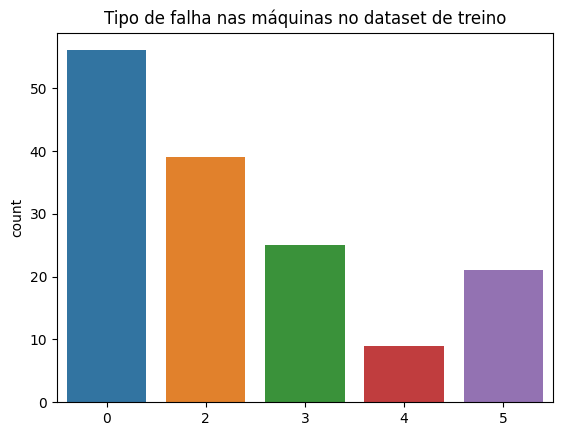

In [48]:
# Plot das falhas no dataset de treino
sns.countplot(x=y_falha_treino)
plt.title('Tipo de falha nas máquinas no dataset de treino');

Nesse caso já possuímos um dataset com classes melhor balanceadas, não precisamos de _oversampling_. No entanto, alguns algoritmos de Machine Learning, como XGBoost, não aceitam receber os labels das _n_ classes fora da ordem 0 até a classe _n_-1. Então faremos um novo encoding, que será desfeito após a previsão.

In [49]:
y_falha_treino_copia = y_falha_treino.copy()
y_falha_val_copia = y_falha_val.copy()

In [50]:
# Novo encoding para ficar no intervalo (0,4)
y_falha_treino[y_falha_treino > 0] = y_falha_treino - 1
y_falha_val[y_falha_val > 0] = y_falha_val - 1

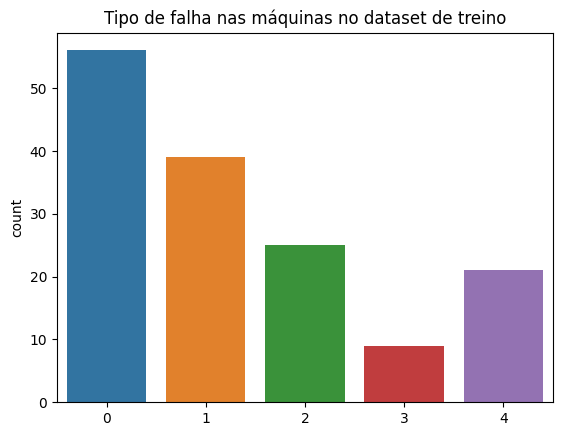

In [51]:
# Plot das falhas no dataset de treino - Após novo encoding
sns.countplot(x=y_falha_treino)
plt.title('Tipo de falha nas máquinas no dataset de treino');

In [52]:
# Criando a função que treina e avalia o modelo multiclasse
def train_and_score_multiclass_model(algoritmo, X_treino, y_treino, X_teste, y_teste, nome = None, version = '1', auc = False):
    # Cria o modelo
    modelo = algoritmo
    
    # Treinamento
    start = time.time()
    modelo.fit(X_treino, y_treino)
    end = time.time()
    print('Tempo de Treinamento do Modelo:', end - start)
    
    # Fazendo as previsões para o dataset de teste
    previsoes = modelo.predict(X_teste)
    
    # Avaliação do modelo
    # Matriz de confusão
    print('\nMatriz de confusão\n', confusion_matrix(y_teste, previsoes))
    
    # Dicionário de métricas e metadados
    dict_model =   {'Modelo': nome,
                    'Versão': version,
                    'Precision':precision_score(y_teste, previsoes, average = 'macro', zero_division=0),
                    'Recall':recall_score(y_teste, previsoes, average = 'macro', zero_division=0),
                    'F1 Score':f1_score(y_teste, previsoes, average = 'macro', zero_division=0),
                    'Acurácia':accuracy_score(y_teste, previsoes)}
    
    if auc:
        dict_model['ROC AUC'] = roc_auc_score(y_teste, previsoes, multi_class='ovr')
        
    return modelo, dict_model, previsoes

In [53]:
# Modelo 1 - KNN - Multiclasse
modelo1_multi, dict1, previsoes1 = train_and_score_multiclass_model(KNeighborsClassifier(), X_falha_treino, y_falha_treino, 
                                                                       X_falha_val, y_falha_val,
                                                                       nome = 'KNN',
                                                                       version = 'Multiclass Classification 1')
dict1

Tempo de Treinamento do Modelo: 0.0019888877868652344

Matriz de confusão
 [[18  0  1  0  0]
 [ 2 10  1  0  0]
 [ 1  2  7  0  6]
 [ 0  1  0  1  1]
 [ 3  0  0  1  3]]


{'Modelo': 'KNN',
 'Versão': 'Multiclass Classification 1',
 'Precision': 0.6194017094017094,
 'Recall': 0.5832007904376326,
 'F1 Score': 0.5838762496053878,
 'Acurácia': 0.6724137931034483}

In [54]:
# Modelo 2 - Naive Bayes - Multiclasse
modelo2_multi, dict2, previsoes2 = train_and_score_multiclass_model(GaussianNB(), X_falha_treino, y_falha_treino, 
                                                                       X_falha_val, y_falha_val,
                                                                       nome = 'Naive Bayes',
                                                                       version = 'Multiclass Classification 1')
dict2

Tempo de Treinamento do Modelo: 0.003003358840942383

Matriz de confusão
 [[ 2  3  0 12  2]
 [ 0 11  0  2  0]
 [ 0  1  3  7  5]
 [ 0  0  1  2  0]
 [ 0  2  0  1  4]]


{'Modelo': 'Naive Bayes',
 'Versão': 'Multiclass Classification 1',
 'Precision': 0.5688057040998218,
 'Recall': 0.4754024484287642,
 'F1 Score': 0.3632804232804233,
 'Acurácia': 0.3793103448275862}

In [55]:
# Modelo 3 - Decision Tree - Multiclasse
modelo3_multi, dict3, previsoes3 = train_and_score_multiclass_model(DecisionTreeClassifier(), X_falha_treino, y_falha_treino, 
                                                                       X_falha_val, y_falha_val,
                                                                       nome = 'Decision Tree Classifier',
                                                                       version = 'Multiclass Classification 1')
dict3

Tempo de Treinamento do Modelo: 0.0030040740966796875

Matriz de confusão
 [[15  1  1  1  1]
 [ 0 11  1  1  0]
 [ 0  1  9  5  1]
 [ 0  0  0  3  0]
 [ 0  0  0  2  5]]


{'Modelo': 'Decision Tree Classifier',
 'Versão': 'Multiclass Classification 1',
 'Precision': 0.7257242757242758,
 'Recall': 0.7824826489300174,
 'F1 Score': 0.7018918336565395,
 'Acurácia': 0.7413793103448276}

In [56]:
# Modelo 4 - Decision Tree - Multiclasse
modelo4_multi, dict4, previsoes4 = train_and_score_multiclass_model(RandomForestClassifier(), X_falha_treino, y_falha_treino, 
                                                                       X_falha_val, y_falha_val,
                                                                       nome = 'Random Forest Classifier',
                                                                       version = 'Multiclass Classification 1')
dict4

Tempo de Treinamento do Modelo: 0.17299342155456543

Matriz de confusão
 [[18  0  1  0  0]
 [ 0 12  1  0  0]
 [ 0  1  9  5  1]
 [ 0  0  1  2  0]
 [ 0  1  0  1  5]]


{'Modelo': 'Random Forest Classifier',
 'Versão': 'Multiclass Classification 1',
 'Precision': 0.7380952380952381,
 'Recall': 0.7627795450163871,
 'F1 Score': 0.7275172275172276,
 'Acurácia': 0.7931034482758621}

In [57]:
# Modelo 5 - SVM Classifier - Multiclasse
modelo5_multi, dict5, previsoes5 = train_and_score_multiclass_model(svm.SVC(), X_falha_treino, y_falha_treino, 
                                                                       X_falha_val, y_falha_val,
                                                                       nome = 'SVM Classifier',
                                                                       version = 'Multiclass Classification 1')
dict5

Tempo de Treinamento do Modelo: 0.0050029754638671875

Matriz de confusão
 [[17  1  1  0  0]
 [ 0 13  0  0  0]
 [ 0  1  9  0  6]
 [ 0  0  0  1  2]
 [ 2  0  0  0  5]]


{'Modelo': 'SVM Classifier',
 'Versão': 'Multiclass Classification 1',
 'Precision': 0.8092037786774628,
 'Recall': 0.7009711779448622,
 'F1 Score': 0.7031231925968768,
 'Acurácia': 0.7758620689655172}

In [58]:
# Modelo 6 - SVM Classifier - Multiclasse
modelo6_multi, dict6, previsoes6 = train_and_score_multiclass_model(XGBClassifier(), X_falha_treino, y_falha_treino, 
                                                                       X_falha_val, y_falha_val,
                                                                       nome = 'XGBoost Classifier',
                                                                       version = 'Multiclass Classification 1')
dict6

Tempo de Treinamento do Modelo: 0.09099984169006348

Matriz de confusão
 [[18  1  0  0  0]
 [ 1 11  0  1  0]
 [ 1  0  9  5  1]
 [ 0  0  0  2  1]
 [ 0  0  0  1  6]]


{'Modelo': 'XGBoost Classifier',
 'Versão': 'Multiclass Classification 1',
 'Precision': 0.7577777777777778,
 'Recall': 0.7759663582032003,
 'F1 Score': 0.7312820512820513,
 'Acurácia': 0.7931034482758621}

In [59]:
resumo_multi1 = pd.DataFrame({'dict1':pd.Series(dict1),
                           'dict2':pd.Series(dict2),
                           'dict3':pd.Series(dict3),
                           'dict4':pd.Series(dict4),
                           'dict5':pd.Series(dict5),
                           'dict6':pd.Series(dict6)})

resumo_multi1

,dict1,dict2,dict3,dict4,dict5,dict6
Modelo,KNN,Naive Bayes,Decision Tree Classifier,Random Forest Classifier,SVM Classifier,XGBoost Classifier
Versão,Multiclass Classification 1,Multiclass Classification 1,Multiclass Classification 1,Multiclass Classification 1,Multiclass Classification 1,Multiclass Classification 1
Precision,0.619402,0.568806,0.725724,0.738095,0.809204,0.757778
Recall,0.583201,0.475402,0.782483,0.76278,0.700971,0.775966
F1 Score,0.583876,0.36328,0.701892,0.727517,0.703123,0.731282
Acurácia,0.672414,0.37931,0.741379,0.793103,0.775862,0.793103


Para o modelo de classificação multiclasse, utilizaremos a métrica F1 Score, que é a média harmônica entre precision e recall para avaliar o modelo. Como agora não temos exatamente uma falha como mais ou menos grave que outra, um bom equilíbrio de falsos positivos e falsos negativos pode ser útil.

Dentre os modelos utilizados para a classificação multiclasse, o Random Forest foi o que melhor respondeu. Vamos utilizar esse modelo como base e fazer um GridSearchCV para encontrar os melhores hiperparâmetros para ele e tentar melhorar a resposta final do modelo.

In [60]:
?modelo4_multi

In [61]:
# Grid Search

# Usando um grid completo de todos os parâmetros
param_grid = {"max_depth": range(3,10,2),
              "min_samples_split": range(1,6),
              "criterion": ['gini', 'entropy', 'log_loss'],
              "n_estimators": range(100,500,100),
              "bootstrap": [True, False]}

# Executando o Grid Search
grid_search = GridSearchCV(modelo4_multi, param_grid = param_grid, return_train_score = True, scoring='f1_macro')
start = time.time()
grid_search.fit(X_falha_treino, y_falha_treino)

print("GridSearchCV executou em %.2f segundos para todas as combinações de candidatos a parâmetros do modelo."
      % (time.time() - start))
grid_search.cv_results_

GridSearchCV executou em 980.33 segundos para todas as combinações de candidatos a parâmetros do modelo.


{'mean_fit_time': array([0.14839993, 0.30980101, 0.45840034, 0.59878712, 0.14742217,
        0.28804512, 0.42707171, 0.58675275, 0.14956779, 0.34985271,
        0.47846341, 0.63070779, 0.15370054, 0.30017109, 0.43686743,
        0.58290906, 0.14741554, 0.29339929, 0.43999958, 0.61764131,
        0.20246139, 0.31959972, 0.46041231, 0.59693446, 0.15058608,
        0.30004678, 0.44827743, 0.6014883 , 0.14860659, 0.29847598,
        0.45386105, 0.5910965 , 0.15725698, 0.30522251, 0.45886798,
        0.58508582, 0.15520277, 0.30019784, 0.44939842, 0.60263958,
        0.20441699, 0.39515023, 0.4736032 , 0.60084233, 0.14922605,
        0.32867012, 0.466645  , 0.64144568, 0.15203967, 0.31458797,
        0.46012454, 0.57393064, 0.14418259, 0.28583927, 0.43527298,
        0.56894784, 0.1455986 , 0.28580146, 0.42900648, 0.57368455,
        0.14583297, 0.2894434 , 0.43226142, 0.58968   , 0.14082122,
        0.29748917, 0.49363041, 0.63876162, 0.14778676, 0.30325623,
        0.45299792, 0.59859743,

In [62]:
grid_search.best_params_

{'bootstrap': False,
 'criterion': 'log_loss',
 'max_depth': 5,
 'min_samples_split': 2,
 'n_estimators': 400}

In [63]:
grid_search.best_score_

0.7765662507427213

A primeira tentativa de otimização dos hiperparâmetros, chegamos a 77,66% de F1 Score. Vamos fazer uma segunda otimização de hiperparâmetros.

In [64]:
# Grid Search 2

# Usando um grid completo de todos os parâmetros
param_grid = {"max_depth": range(3,10,1),
              "min_samples_split": range(1,4),
              "max_features": ['sqrt', 'log2'],
              "criterion": ['gini', 'entropy', 'log_loss'],
              "n_estimators": range(400,600,100),
              "bootstrap": [True, False]}

# Executando o Grid Search
grid_search = GridSearchCV(modelo4_multi, param_grid = param_grid, return_train_score = True, scoring = 'f1_macro')
start = time.time()
grid_search.fit(X_falha_treino, y_falha_treino)

print("GridSearchCV executou em %.2f segundos para todas as combinações de candidatos a parâmetros do modelo."
      % (time.time() - start))
grid_search.cv_results_

GridSearchCV executou em 2125.31 segundos para todas as combinações de candidatos a parâmetros do modelo.


{'mean_fit_time': array([0.6382925 , 0.86337924, 0.57826548, 0.70983901, 0.571874  ,
        0.71210365, 0.58989124, 0.73408246, 0.59889526, 0.7369154 ,
        0.57488723, 0.723105  , 0.58667922, 0.72871199, 0.58188357,
        0.7250988 , 0.58628983, 0.76479602, 0.6044445 , 0.76331239,
        0.7064805 , 0.7845706 , 0.58929691, 0.73530822, 0.59529271,
        0.73371525, 0.59650488, 0.72667532, 0.58269153, 0.7389071 ,
        0.5940865 , 0.76409888, 0.75295868, 0.85536556, 0.70210891,
        0.81454892, 0.65831013, 0.90626774, 0.66989775, 0.90212126,
        0.6170023 , 0.84601102, 0.63369417, 1.06143317, 0.68740082,
        0.83952179, 0.62766051, 0.77974248, 0.66195388, 0.76015978,
        0.74020085, 0.79356089, 0.59739933, 0.811936  , 0.62449784,
        0.77814097, 0.62173967, 0.76629853, 0.6168716 , 0.75740499,
        0.61559772, 0.75930037, 0.59636464, 0.77853909, 0.61580095,
        0.80820456, 0.70891356, 0.80743051, 0.63451147, 0.76935587,
        0.61636415, 0.75853753,

In [65]:
grid_search.best_params_

{'bootstrap': False,
 'criterion': 'log_loss',
 'max_depth': 5,
 'max_features': 'log2',
 'min_samples_split': 3,
 'n_estimators': 500}

In [66]:
grid_search.best_score_

0.7899089273897457

A segunda tentativa de otimização não resultou em uma melhora expressiva da métrica, vamos ver como fica a matriz de confusão e a acurácia do modelo em teste.

In [67]:
previsoes_multi = grid_search.predict(X_falha_val)

# Avaliação do modelo
# Matriz de confusão
print('\nMatriz de confusão\n', confusion_matrix(y_falha_val, previsoes_multi))

# Dicionário de métricas e metadados
dict_model =   {'Modelo': 'XGBoost Classifier Grid Search 2',
                'Versão': 'Otimizada',
                'Precision':precision_score(y_falha_val, previsoes_multi, average = 'macro', zero_division=0),
                'Recall':recall_score(y_falha_val, previsoes_multi, average = 'macro', zero_division=0),
                'F1 Score':f1_score(y_falha_val, previsoes_multi, average = 'macro', zero_division=0),
                'Acurácia':accuracy_score(y_falha_val, previsoes_multi)}

dict_model


Matriz de confusão
 [[19  0  0  0  0]
 [ 0 11  1  1  0]
 [ 0  1  9  5  1]
 [ 0  0  0  3  0]
 [ 0  0  0  1  6]]


{'Modelo': 'XGBoost Classifier Grid Search 2',
 'Versão': 'Otimizada',
 'Precision': 0.7947619047619047,
 'Recall': 0.8531593406593407,
 'F1 Score': 0.7781978021978022,
 'Acurácia': 0.8275862068965517}

In [68]:
previsoes_multi

array([3, 0, 3, 4, 1, 0, 2, 2, 0, 3, 4, 1, 1, 0, 4, 2, 4, 0, 2, 0, 0, 3,
       0, 1, 0, 1, 2, 0, 0, 1, 3, 1, 3, 0, 0, 1, 0, 3, 0, 4, 3, 0, 3, 2,
       2, 0, 1, 4, 1, 2, 1, 2, 0, 4, 0, 3, 2, 1])

No nosso conjunto de dados de validação, o modelo acertou todas 48 das 58 previsões, atingindo 82,75% de acurácia. Vamos usar esse como o segundo modelo do nosso pipeline para fazer as previsões completas e ver como ficam as métricas.

# Avaliação do pipeline completo

Ao longo da modelagem, construímos 2 modelos preditivos. Um de classificação binária, para prever se havia ou não falha nas máquinas, e outro de classificação multiclasse, para prever se, dado que o modelo previu que havia uma falha, que tipo de falha ela seria. O segundo modelo ainda pode classificar como "No Failure", sendo assim um segundo filtro. 

Avaliamos cada modelo e suas previsões separadamente, mas é interessante prever 

In [69]:
prev_bin = modelo3.predict(X_val) # Previsoes do modelo binario

validacao_com_prev = X_val.copy()
validacao_com_prev['prediction'] = prev_bin

prev_falha = X_val[prev_bin == 0] # Registros em que o primeiro modelo previu falha

prev_multi = grid_search.predict(prev_falha)# Previsões do modelo multiclasse
prev_multi = np.where(prev_multi == 0, prev_multi, prev_multi+1) # Convertendo de volta para o encoding original

validacao_com_prev_slice =  prev_falha.copy()
validacao_com_prev_slice['prediction'] = prev_multi

validacao_com_prev.loc[prev_falha.index] = validacao_com_prev_slice

validacao_com_prev


,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,H,L,M,prediction
5089,0.206892,0.948209,0.698529,-1.078106,0.524390,0.0,1.0,0.0,1
2028,0.307330,-0.059381,-0.499925,0.232524,0.686992,0.0,0.0,1.0,1
2438,1.060613,0.881037,-0.691228,0.402605,0.174797,0.0,1.0,0.0,1
4076,0.457986,0.612346,-0.342382,0.142480,0.406504,0.0,1.0,0.0,1
2330,0.809518,0.343655,0.360936,-0.777961,0.008130,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...
6252,-1.249456,-1.335661,2.785976,-2.338711,0.520325,0.0,0.0,1.0,1
6532,-0.747267,-0.529589,1.030495,-1.068101,0.691057,0.0,0.0,1.0,1
6002,-1.400113,-1.335661,0.940470,-1.408264,0.813008,0.0,1.0,0.0,1
664,-1.902302,-2.141734,0.659143,-0.898019,0.552846,0.0,1.0,0.0,1


In [70]:
# Matriz de confusão
confusion_matrix(y_val,validacao_com_prev['prediction'])

array([[  18,    1,    0,    0,    0,    0],
       [  13, 1557,    9,    4,   12,   14],
       [   0,    1,   11,    1,    0,    0],
       [   0,    9,    1,    6,    0,    0],
       [   0,    3,    0,    0,    0,    0],
       [   0,    6,    0,    0,    0,    1]], dtype=int64)

In [71]:
f1_score(y_val, validacao_com_prev['prediction'], average = 'weighted', zero_division=0)

0.9612943356523417

In [72]:
f1_score(y_val, validacao_com_prev['prediction'], average = 'macro', zero_division=0)

0.47996891480440834

In [73]:
accuracy_score(y_val, validacao_com_prev['prediction'])

0.9556088782243551

Atingimos um F1 Score de 98,47%. Podemos então partir para previsão em novos dados.

# Previsões para o conjunto sem labels

O objetivo final da modelagem era utilizar o modelo para prever o tipo de falha em 3333 registros que estão armazenados na variável _df\_teste_. Para isso, contudo, precisamos aplicar todas as transformações que foram feitas na etapa de pré-processamento, como encoding, padronização e normalização. O LabelEncoding da variável target não é necessário visto que esse conjunto de dados não possui labels.

In [74]:
df_teste = pd.read_csv("desafio_manutencao_preditiva_teste.csv")

In [75]:
df_teste = df_teste.drop(columns = ['udi', 'product_id'])

# One Hot Encoding
cat_encoded_teste = onehot.transform(df_teste[[categorical]])
df_teste[onehot.categories_[0]] = cat_encoded_teste.toarray()
df_teste.drop(columns='type', inplace = True)

# Scaling
df_teste[scale] = scaler.transform(df_teste[scale])

# Normalizing
df_teste[normalize] = normalizer.transform(df_teste[normalize])

df_teste

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,H,L,M
0,-1.249456,-0.932625,1.435606,-1.338230,0.284553,0.0,1.0,0.0
1,0.357548,0.343655,-0.010416,0.732764,0.780488,0.0,1.0,0.0
2,-1.400113,-1.066971,-0.438033,0.202509,0.166667,0.0,1.0,0.0
3,-0.295297,-0.596762,0.743541,-0.417789,0.276423,0.0,1.0,0.0
4,2.064991,2.090145,0.068356,-0.918029,0.036585,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
3328,1.261488,1.284073,-1.304521,1.963354,0.699187,0.0,1.0,0.0
3329,0.357548,0.679519,-0.702481,1.192985,0.369919,0.0,1.0,0.0
3330,0.407767,0.813864,-0.319876,-0.157664,0.735772,0.0,1.0,0.0
3331,1.412145,1.485591,-0.162333,-0.357760,0.211382,0.0,1.0,0.0


In [76]:
# Previsões do Modelo de classificação binária
previsoes_finais_bin = modelo3.predict(df_teste)
previsoes_finais_bin

array([1, 1, 1, ..., 1, 1, 1])

In [77]:
# Salvando os resultados intermediários num novo DataFrame
df_final = df_teste.copy()
df_final['prediction'] = previsoes_finais_bin

df_final

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,H,L,M,prediction
0,-1.249456,-0.932625,1.435606,-1.338230,0.284553,0.0,1.0,0.0,1
1,0.357548,0.343655,-0.010416,0.732764,0.780488,0.0,1.0,0.0,1
2,-1.400113,-1.066971,-0.438033,0.202509,0.166667,0.0,1.0,0.0,1
3,-0.295297,-0.596762,0.743541,-0.417789,0.276423,0.0,1.0,0.0,1
4,2.064991,2.090145,0.068356,-0.918029,0.036585,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...
3328,1.261488,1.284073,-1.304521,1.963354,0.699187,0.0,1.0,0.0,0
3329,0.357548,0.679519,-0.702481,1.192985,0.369919,0.0,1.0,0.0,1
3330,0.407767,0.813864,-0.319876,-0.157664,0.735772,0.0,1.0,0.0,1
3331,1.412145,1.485591,-0.162333,-0.357760,0.211382,0.0,1.0,0.0,1


In [78]:
# Conjunto de dados cujo modelo de classificação binária previu como falha
df_teste2 = df_teste[previsoes_finais_bin == 0]
df_teste2

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,H,L,M
118,-0.948143,-1.604352,2.318973,-1.978538,0.821138,0.0,1.0,0.0
139,0.960175,-0.260899,-0.719360,0.892841,0.906504,0.0,1.0,0.0
160,0.407767,1.351246,-1.484570,2.723719,0.646341,0.0,0.0,1.0
175,-0.596610,0.410828,1.491871,-1.468293,0.849593,0.0,1.0,0.0
183,-0.044203,0.881037,-0.612456,1.813282,0.418699,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
3308,-0.496173,0.276483,-0.972555,0.902845,0.918699,0.0,1.0,0.0
3309,-1.550769,-1.470007,-0.775626,1.703230,0.821138,0.0,1.0,0.0
3310,-1.500550,-1.470007,-1.248255,2.113426,0.813008,0.0,1.0,0.0
3311,1.713458,1.216900,-0.769999,1.293033,0.845528,0.0,1.0,0.0


In [79]:
# Previsões do Modelo de classificação multiclasse
previsoes_finais = grid_search.predict(df_teste2)
previsoes_finais = np.where(previsoes_finais == 0, previsoes_finais, previsoes_finais+1)

In [80]:
df_final_slice = df_teste2.copy()
df_final_slice['prediction'] = previsoes_finais

df_final_slice

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,H,L,M,prediction
118,-0.948143,-1.604352,2.318973,-1.978538,0.821138,0.0,1.0,0.0,5
139,0.960175,-0.260899,-0.719360,0.892841,0.906504,0.0,1.0,0.0,2
160,0.407767,1.351246,-1.484570,2.723719,0.646341,0.0,0.0,1.0,3
175,-0.596610,0.410828,1.491871,-1.468293,0.849593,0.0,1.0,0.0,5
183,-0.044203,0.881037,-0.612456,1.813282,0.418699,0.0,1.0,0.0,4
...,...,...,...,...,...,...,...,...,...
3308,-0.496173,0.276483,-0.972555,0.902845,0.918699,0.0,1.0,0.0,2
3309,-1.550769,-1.470007,-0.775626,1.703230,0.821138,0.0,1.0,0.0,2
3310,-1.500550,-1.470007,-1.248255,2.113426,0.813008,0.0,1.0,0.0,2
3311,1.713458,1.216900,-0.769999,1.293033,0.845528,0.0,1.0,0.0,2


In [81]:
df_final.loc[df_final_slice.index] = df_final_slice

In [82]:
df_final

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,H,L,M,prediction
0,-1.249456,-0.932625,1.435606,-1.338230,0.284553,0.0,1.0,0.0,1
1,0.357548,0.343655,-0.010416,0.732764,0.780488,0.0,1.0,0.0,1
2,-1.400113,-1.066971,-0.438033,0.202509,0.166667,0.0,1.0,0.0,1
3,-0.295297,-0.596762,0.743541,-0.417789,0.276423,0.0,1.0,0.0,1
4,2.064991,2.090145,0.068356,-0.918029,0.036585,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...
3328,1.261488,1.284073,-1.304521,1.963354,0.699187,0.0,1.0,0.0,0
3329,0.357548,0.679519,-0.702481,1.192985,0.369919,0.0,1.0,0.0,1
3330,0.407767,0.813864,-0.319876,-0.157664,0.735772,0.0,1.0,0.0,1
3331,1.412145,1.485591,-0.162333,-0.357760,0.211382,0.0,1.0,0.0,1


In [83]:
df_final['prediction'].nunique()

6

# Convertendo os resultados de volta para os labels

Quando fizemos o LabelEncoding da variável target, os labels tornaram-se valores numéricos. Para leitura humana, o resultado final tem mais valor sendo transformado de volta para os labels originais.

In [84]:
previsoes_finais_transformadas = pd.Series(le.inverse_transform(df_final['prediction']))
previsoes_finais_transformadas

0                     No Failure
1                     No Failure
2                     No Failure
3                     No Failure
4                     No Failure
                  ...           
3328    Heat Dissipation Failure
3329                  No Failure
3330                  No Failure
3331                  No Failure
3332                  No Failure
Length: 3333, dtype: object

In [85]:
# Quantidade de previsões de cada tipo
previsoes_finais_transformadas.value_counts()

No Failure                  3125
Tool Wear Failure             56
Heat Dissipation Failure      56
Overstrain Failure            42
Power Failure                 32
Random Failures               22
dtype: int64

# Salvando os resultados num arquivo CSV

Para finalizar o trabalho, salvamos os resultados finais num arquivo CSV.

In [86]:
previsoes_finais_transformadas = previsoes_finais_transformadas.reset_index()

In [87]:
previsoes_finais_transformadas.to_csv("predicted.csv", index = False, header=['rowNumber','predictedValues'])